<a href="https://colab.research.google.com/github/RashmiGohil/Scaler-projects/blob/main/OLA_ENSEMBLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#1. Data Loading and Initial Exploration
import pandas as pd

# Load the dataset
url='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv'
df = pd.read_csv(url)

In [3]:
#Display the first 5 rows
print(df.head())

   Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0           0  01/01/19          1  28.0     0.0  C23                2   
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0   57387      24/12/18             NaN                    1      1   
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 

In [4]:
#display the information about alll the columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB
None


In [5]:
#check for missing values
print(df.isnull().sum())

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64


In [7]:
#date conversion
#convert date columns to datetime format
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'],errors='coerce')
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'],errors='coerce')
df['MMM-YY']=pd.to_datetime(df['MMM-YY'],format='%B-%y',errors='coerce')

In [8]:
#Handling missing values with KNN Imputation
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [9]:
#select numerical columns for imputation
num_cols=df.select_dtypes(include=['float64','int64']).columns
df_num=df[num_cols]

In [10]:
#Standardise the numerical features
scaler=StandardScaler()
df_num_scaled=scaler.fit_transform(df_num)

In [11]:
# Apply KNN Imputation
imputer = KNNImputer(n_neighbors=5)
df_num_imputed = imputer.fit_transform(df_num_scaled)

In [12]:
# Replace the original numerical data with imputed data
df[num_cols] = scaler.inverse_transform(df_num_imputed)

In [14]:
#4. Data Aggregation per Driver
# Aggregate data by Driver_ID
agg_funcs = {
    'Age': 'first',
    'Gender': 'first',
    'City': 'first',
    'Education_Level': 'first',
    'Income': 'mean',
    'Dateofjoining': 'first',
    'LastWorkingDate': 'last',
    'Joining Designation': 'first',
    'Grade': 'last',
    'Total Business Value': 'mean',
    'Quarterly Rating': 'mean'
}
df_agg = df.groupby('Driver_ID').agg(agg_funcs).reset_index()

In [15]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0.0,NaT,1.0,28.0,0.0,C23,2.0,57387.0,2018-12-24,NaT,1.0,1.0,2.381060e+06,2.0
1,1.0,NaT,1.0,28.0,0.0,C23,2.0,57387.0,2018-12-24,NaT,1.0,1.0,-6.654800e+05,2.0
2,2.0,NaT,1.0,28.0,0.0,C23,2.0,57387.0,2018-12-24,2019-03-11,1.0,1.0,1.164153e-10,2.0
3,3.0,NaT,2.0,31.0,0.0,C7,2.0,67016.0,2020-11-06,NaT,2.0,2.0,1.164153e-10,1.0
4,4.0,NaT,2.0,31.0,0.0,C7,2.0,67016.0,2020-11-06,NaT,2.0,2.0,1.164153e-10,1.0


In [16]:
#5. Feature Engineering
# Create target variable: 1 if LastWorkingDate is present, else 0
df_agg['target'] = df_agg['LastWorkingDate'].notnull().astype(int)

In [19]:
# Create binary feature for income increase
df_income = df[['Driver_ID', 'MMM-YY', 'Income']].sort_values(by=['Driver_ID', 'MMM-YY'])
df_income['Income_Change'] = df_income.groupby('Driver_ID')['Income'].diff()
df_income['Income_Increase'] = (df_income['Income_Change'] > 0).astype(int)
income_increase = df_income.groupby('Driver_ID')['Income_Increase'].max().reset_index()
df_agg = df_agg.merge(income_increase, on='Driver_ID', how='left')

In [20]:
# Create binary feature for quarterly rating increase
df_rating = df[['Driver_ID', 'MMM-YY', 'Quarterly Rating']].sort_values(by=['Driver_ID', 'MMM-YY'])
df_rating['Rating_Change'] = df_rating.groupby('Driver_ID')['Quarterly Rating'].diff()
df_rating['Rating_Increase'] = (df_rating['Rating_Change'] > 0).astype(int)
rating_increase = df_rating.groupby('Driver_ID')['Rating_Increase'].max().reset_index()
df_agg = df_agg.merge(rating_increase, on='Driver_ID', how='left')

In [21]:
#6. Encoding Categorical Variables
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_agg, columns=['Gender', 'City', 'Education_Level', 'Grade'], drop_first=True)

In [22]:
#7 7. Handling Class Imbalance with SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [24]:
# Define features and target
X = df_encoded.drop(['Driver_ID', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'target'], axis=1)
y = df_encoded['target']

In [25]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [27]:
#8. Feature Scaling
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [28]:
#9. Model Building with Ensemble Methods
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [29]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

In [30]:
# Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train_scaled, y_train_res)
y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

In [31]:
#10. Model Evaluation
# Evaluation for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       153
           1       0.81      0.82      0.82       324

    accuracy                           0.75       477
   macro avg       0.71      0.71      0.71       477
weighted avg       0.75      0.75      0.75       477

Random Forest Confusion Matrix:
[[ 91  62]
 [ 57 267]]
Random Forest ROC AUC Score: 0.7833353506011458


In [32]:
# Evaluation for Gradient Boosting
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("Gradient Boosting ROC AUC Score:", roc_auc_score(y_test, y_proba_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       153
           1       0.82      0.82      0.82       324

    accuracy                           0.76       477
   macro avg       0.72      0.72      0.72       477
weighted avg       0.76      0.76      0.76       477

Gradient Boosting Confusion Matrix:
[[ 94  59]
 [ 57 267]]
Gradient Boosting ROC AUC Score: 0.7993221980150085


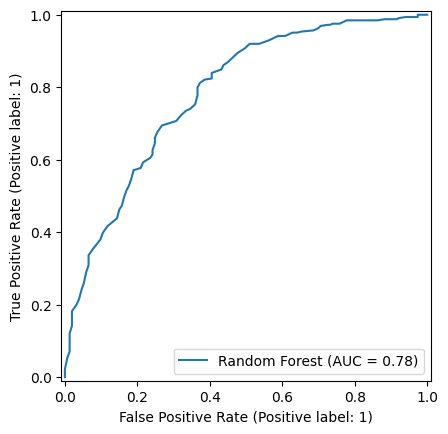

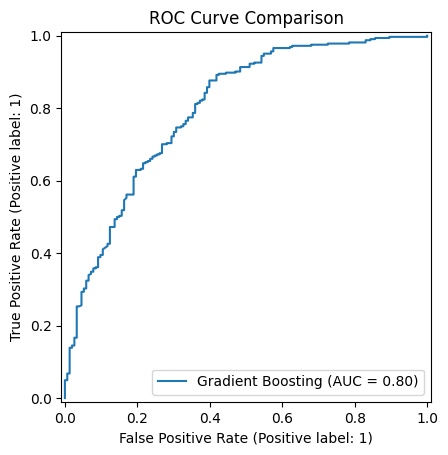

In [33]:
# Plot ROC Curve for both models
RocCurveDisplay.from_estimator(rf, X_test_scaled, y_test, name='Random Forest')
RocCurveDisplay.from_estimator(gb, X_test_scaled, y_test, name='Gradient Boosting')
plt.title('ROC Curve Comparison')
plt.show()

11. Actionable Recommendations
* Based on the analysis and model predictions:

1.Focus on Recall: Prioritize models with higher recall to ensure most at-risk drivers are identified, even if it means more false positives.

2.Driver Segmentation: Identify segments (e.g., age groups, cities) with higher attrition rates for targeted interventions.

3.Performance Monitoring: Regularly track key performance indicators like Quarterly Rating and Income to proactively address declines.

4.Retention Strategies: Develop personalized incentives and flexible working conditions for drivers showing early signs of disengagement.

5.Threshold Adjustment: Adjust the decision threshold based on business priorities:

6.Lower threshold for higher recall (retain more drivers).

7.Higher threshold for higher precision (cost-saving).